In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#Reconstruct results of ETL Notebook
data = pd.read_csv("/content/drive/MyDrive/Learning/Data Science/IBM Advanced DS Certification/train.txt", delimiter= " ", header = None)
data = data.iloc[:, 0:26]
colNames = ["UnitNumber", "TimeCycle", "OpSetting1", "OpSetting2", "OpSetting3"]
sensorCols = ["SensorMeasurement_" + str(x) for x in range(1, 22)]
colNames.extend(sensorCols)
data.columns = colNames
#Compute Lifetime for each TurboFan Engine
usefulLife_df = pd.DataFrame(data["UnitNumber"].value_counts())
usefulLife_df.columns = ["UnitLife"]
usefulLife_df["UnitNumber"] = usefulLife_df.index
usefulLife_df = usefulLife_df.sort_values("UnitNumber")
usefulLife_df = usefulLife_df[["UnitNumber", "UnitLife"]].reset_index(drop = True)
#We'll join the `UnitLife` variable onto the original dataset and computer RUL
data = data.merge(usefulLife_df, how = "left", on = "UnitNumber")
data["RUL"] = data["TimeCycle"] - data["UnitLife"]

#Print out the current form of the dataset
data.head()

UnitNumber  TimeCycle  OpSetting1  OpSetting2  OpSetting3  \
0           1          1     10.0047      0.2501        20.0   
1           1          2      0.0015      0.0003       100.0   
2           1          3     34.9986      0.8401        60.0   
3           1          4     20.0031      0.7005         0.0   
4           1          5     42.0041      0.8405        40.0   

   SensorMeasurement_1  SensorMeasurement_2  SensorMeasurement_3  \
0               489.05               604.13              1499.45   
1               518.67               642.13              1584.55   
2               449.44               555.42              1368.17   
3               491.19               607.03              1488.44   
4               445.00               549.52              1354.48   

   SensorMeasurement_4  SensorMeasurement_5  ...  SensorMeasurement_14  \
0              1309.95                10.52  ...               8120.83   
1              1403.96                14.62  ...               8132.87   
2              1122.49                 5.48  ...               8063.84   
3              1249.18                 9.35  ...               8052.30   
4              1124.32                 3.91  ...               8083.67   

   SensorMeasurement_15  SensorMeasurement_16  SensorMeasurement_17  \
0                8.6216                  0.03                   368   
1                8.3907                  0.03                   391   
2                9.3557                  0.02                   334   
3                9.2231                  0.02                   364   
4                9.2986                  0.02                   330   

   SensorMeasurement_18  SensorMeasurement_19  SensorMeasurement_20  \
0                  2319                 100.0                 28.58   
1                  2388                 100.0                 38.99   
2                  2223                 100.0                 14.83   
3                  2324                 100.0                 24.42   
4                  2212                 100.0                 10.99   

   SensorMeasurement_21  UnitLife  RUL  
0               17.1735       223 -222  
1               23.3619       223 -221  
2                8.8555       223 -220  
3               14.7832       223 -219  
4                6.4025       223 -218  

[5 rows x 28 columns]

## Preparing for EDA and Model Construction

Now that the dataset is cleaned and our response feature has been engineered, we'll explore our data a bit more and prepare for an analysis, model construction, testing, and iteration. In particular, a first step should be to note how many engines we are working with and to randomly select engines for inclusion in the training, test, and safe sets.

Eventually we will create a separate version of our dataset with standardized sensor measurements -- we will do this just prior to the model-building phase.

In [2]:
data["UnitNumber"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Now that we know we have 218 engines, we'll proceed with splitting our data. I'll put approximately 70% of the engines into the training set, 20% into the test set, and leave 10% in the safe for final validation.

In [3]:
#Create a list of engines (unique unit numbers)
engines = list(data["UnitNumber"].unique())
print(engines[:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [4]:
#Function to shuffle and split engines into training, test, and safe sets
def split_units(units, random_state = 42, train_size = 0.7, test_size = 0.2):
  units2 = units.copy()
  random.Random(42).shuffle(units2)
  #print(units2)
  trainUnits = units2[:int(train_size*len(units))]
  testUnits = units2[int(train_size*len(units)):int((train_size + test_size)*len(units))]
  safeUnits = units2[int((train_size + test_size)*len(units)):]

  return trainUnits, testUnits, safeUnits

In [5]:
#Split engines into training, test, and safe sets -- ensuring no engines have been lost.
trainUnits, testUnits, safeUnits = split_units(engines, random_state = 42, train_size = 0.7, test_size = 0.2)

print(sorted(trainUnits))
print(sorted(testUnits))
print(sorted(safeUnits))

print(len(trainUnits) + len(testUnits) + len(safeUnits) == len(engines))

[1, 3, 4, 5, 6, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 26, 28, 30, 31, 33, 34, 35, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 61, 62, 64, 65, 66, 67, 69, 70, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 90, 91, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 139, 141, 143, 145, 146, 147, 149, 150, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 165, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 181, 182, 183, 185, 186, 187, 188, 191, 193, 194, 195, 197, 198, 201, 202, 204, 205, 207, 208, 210, 211, 212, 213, 214, 217, 218]
[2, 12, 18, 21, 25, 32, 40, 41, 50, 51, 57, 59, 68, 72, 76, 87, 88, 89, 92, 93, 97, 98, 108, 115, 118, 138, 142, 144, 148, 151, 155, 166, 167, 179, 180, 184, 192, 196, 199, 200, 203, 206, 209, 216]
[7, 8, 9, 23, 24, 27, 29, 36, 56, 58, 60, 63, 71, 109, 130, 140, 152, 164, 174, 189, 190, 215]
True


In [6]:
#Create training, test, and safe sets corresponding to engines chosen above
trainUnitsData = data[data["UnitNumber"].isin(trainUnits)].copy()
testUnitsData = data[data["UnitNumber"].isin(testUnits)].copy()
safeUnitsData = data[data["UnitNumber"].isin(safeUnits)].copy()

trainUnitsData.head()

UnitNumber  TimeCycle  OpSetting1  OpSetting2  OpSetting3  \
0           1          1     10.0047      0.2501        20.0   
1           1          2      0.0015      0.0003       100.0   
2           1          3     34.9986      0.8401        60.0   
3           1          4     20.0031      0.7005         0.0   
4           1          5     42.0041      0.8405        40.0   

   SensorMeasurement_1  SensorMeasurement_2  SensorMeasurement_3  \
0               489.05               604.13              1499.45   
1               518.67               642.13              1584.55   
2               449.44               555.42              1368.17   
3               491.19               607.03              1488.44   
4               445.00               549.52              1354.48   

   SensorMeasurement_4  SensorMeasurement_5  ...  SensorMeasurement_14  \
0              1309.95                10.52  ...               8120.83   
1              1403.96                14.62  ...               8132.87   
2              1122.49                 5.48  ...               8063.84   
3              1249.18                 9.35  ...               8052.30   
4              1124.32                 3.91  ...               8083.67   

   SensorMeasurement_15  SensorMeasurement_16  SensorMeasurement_17  \
0                8.6216                  0.03                   368   
1                8.3907                  0.03                   391   
2                9.3557                  0.02                   334   
3                9.2231                  0.02                   364   
4                9.2986                  0.02                   330   

   SensorMeasurement_18  SensorMeasurement_19  SensorMeasurement_20  \
0                  2319                 100.0                 28.58   
1                  2388                 100.0                 38.99   
2                  2223                 100.0                 14.83   
3                  2324                 100.0                 24.42   
4                  2212                 100.0                 10.99   

   SensorMeasurement_21  UnitLife  RUL  
0               17.1735       223 -222  
1               23.3619       223 -221  
2                8.8555       223 -220  
3               14.7832       223 -219  
4                6.4025       223 -218  

[5 rows x 28 columns]

Now we proceed with some basic data visualization. We start with the distributions of the individual features. We see evidence below that the majority of the settings and sensors are measuring a series of discrete states, with noise causing various levels of distortion. In the majority of the cases, the noise is not consequential, but there are a few cases (Sensors 6 and 9) where the noise seems to cause uncertainty in the measured state.

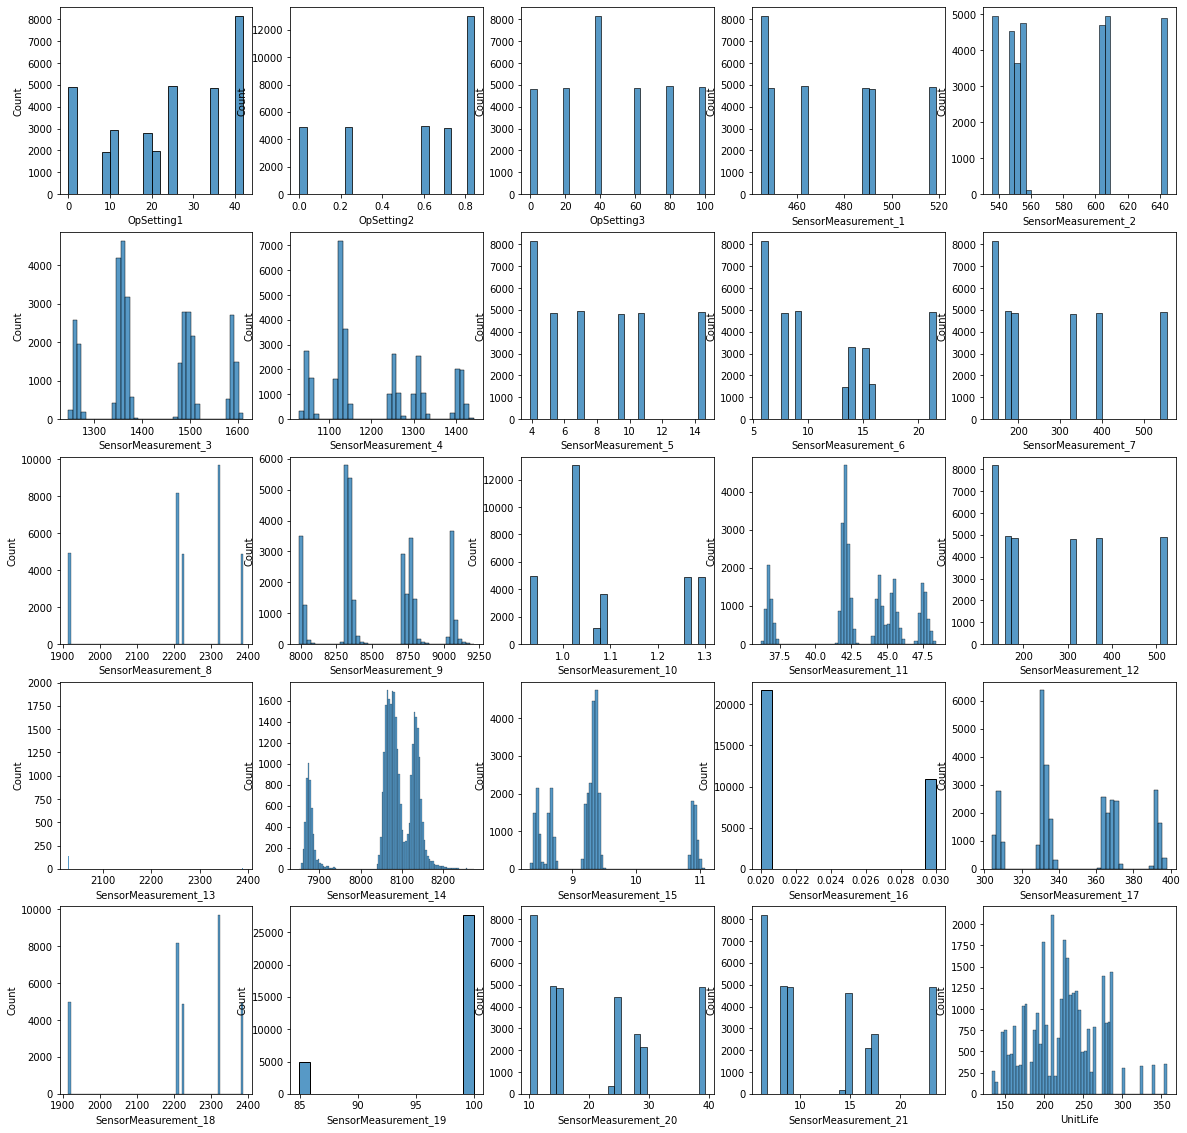

In [7]:
plt.figure(figsize = (20, 20))

for i in range(2, trainUnitsData.shape[1] - 1):
  plt.subplot(5, 5, i-1)
  sns.histplot(trainUnitsData[trainUnitsData.columns[i]]);

Let's take a look at how the Operational Settings have been combined for these engines.

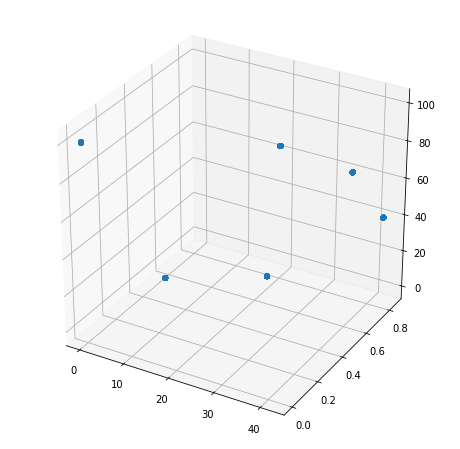

In [8]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = "3d")

ax.scatter(trainUnitsData["OpSetting1"], trainUnitsData["OpSetting2"], trainUnitsData["OpSetting3"])

It seems that there are only six operational setting configurations. Let's recode the three `OpSetting` columns into a single column `OpConfig`.

In [9]:
trainUnitsData.head()

UnitNumber  TimeCycle  OpSetting1  OpSetting2  OpSetting3  \
0           1          1     10.0047      0.2501        20.0   
1           1          2      0.0015      0.0003       100.0   
2           1          3     34.9986      0.8401        60.0   
3           1          4     20.0031      0.7005         0.0   
4           1          5     42.0041      0.8405        40.0   

   SensorMeasurement_1  SensorMeasurement_2  SensorMeasurement_3  \
0               489.05               604.13              1499.45   
1               518.67               642.13              1584.55   
2               449.44               555.42              1368.17   
3               491.19               607.03              1488.44   
4               445.00               549.52              1354.48   

   SensorMeasurement_4  SensorMeasurement_5  ...  SensorMeasurement_14  \
0              1309.95                10.52  ...               8120.83   
1              1403.96                14.62  ...               8132.87   
2              1122.49                 5.48  ...               8063.84   
3              1249.18                 9.35  ...               8052.30   
4              1124.32                 3.91  ...               8083.67   

   SensorMeasurement_15  SensorMeasurement_16  SensorMeasurement_17  \
0                8.6216                  0.03                   368   
1                8.3907                  0.03                   391   
2                9.3557                  0.02                   334   
3                9.2231                  0.02                   364   
4                9.2986                  0.02                   330   

   SensorMeasurement_18  SensorMeasurement_19  SensorMeasurement_20  \
0                  2319                 100.0                 28.58   
1                  2388                 100.0                 38.99   
2                  2223                 100.0                 14.83   
3                  2324                 100.0                 24.42   
4                  2212                 100.0                 10.99   

   SensorMeasurement_21  UnitLife  RUL  
0               17.1735       223 -222  
1               23.3619       223 -221  
2                8.8555       223 -220  
3               14.7832       223 -219  
4                6.4025       223 -218  

[5 rows x 28 columns]

In [10]:
trainUnitsData["OpConfig"] = len(trainUnitsData)*[0]

for i in range(len(trainUnitsData)):
  if trainUnitsData.iloc[i, 4] > 80:
    trainUnitsData.iloc[i, -1] = 1
  
  elif trainUnitsData.iloc[i, 2] < 10:
    trainUnitsData.iloc[i, -1] = 2
  
  elif trainUnitsData.iloc[i, 4] < 20:
    trainUnitsData.iloc[i, -1] = 3
  
  elif trainUnitsData.iloc[i, 2] > 40:
    trainUnitsData.iloc[i, -1] = 4

  elif trainUnitsData.iloc[i, 2] > 30:
    trainUnitsData.iloc[i, -1] = 5
  
  else:
    trainUnitsData.iloc[i, -1] = 6

trainUnitsData["OpConfig"].value_counts()

6    8852
4    8177
1    4901
5    4862
3    4798
2     970
Name: OpConfig, dtype: int64

In [11]:
trainUnitsData = trainUnitsData[['UnitNumber', 'TimeCycle', 'OpConfig',
       'SensorMeasurement_1', 'SensorMeasurement_2', 'SensorMeasurement_3',
       'SensorMeasurement_4', 'SensorMeasurement_5', 'SensorMeasurement_6',
       'SensorMeasurement_7', 'SensorMeasurement_8', 'SensorMeasurement_9',
       'SensorMeasurement_10', 'SensorMeasurement_11', 'SensorMeasurement_12',
       'SensorMeasurement_13', 'SensorMeasurement_14', 'SensorMeasurement_15',
       'SensorMeasurement_16', 'SensorMeasurement_17', 'SensorMeasurement_18',
       'SensorMeasurement_19', 'SensorMeasurement_20', 'SensorMeasurement_21',
       'UnitLife', 'RUL']]

trainUnitsData.head()

UnitNumber  TimeCycle  OpConfig  SensorMeasurement_1  SensorMeasurement_2  \
0           1          1         6               489.05               604.13   
1           1          2         1               518.67               642.13   
2           1          3         5               449.44               555.42   
3           1          4         3               491.19               607.03   
4           1          5         4               445.00               549.52   

   SensorMeasurement_3  SensorMeasurement_4  SensorMeasurement_5  \
0              1499.45              1309.95                10.52   
1              1584.55              1403.96                14.62   
2              1368.17              1122.49                 5.48   
3              1488.44              1249.18                 9.35   
4              1354.48              1124.32                 3.91   

   SensorMeasurement_6  SensorMeasurement_7  ...  SensorMeasurement_14  \
0                15.49               394.88  ...               8120.83   
1                21.61               553.67  ...               8132.87   
2                 8.00               194.93  ...               8063.84   
3                13.65               334.82  ...               8052.30   
4                 5.71               138.24  ...               8083.67   

   SensorMeasurement_15  SensorMeasurement_16  SensorMeasurement_17  \
0                8.6216                  0.03                   368   
1                8.3907                  0.03                   391   
2                9.3557                  0.02                   334   
3                9.2231                  0.02                   364   
4                9.2986                  0.02                   330   

   SensorMeasurement_18  SensorMeasurement_19  SensorMeasurement_20  \
0                  2319                 100.0                 28.58   
1                  2388                 100.0                 38.99   
2                  2223                 100.0                 14.83   
3                  2324                 100.0                 24.42   
4                  2212                 100.0                 10.99   

   SensorMeasurement_21  UnitLife  RUL  
0               17.1735       223 -222  
1               23.3619       223 -221  
2                8.8555       223 -220  
3               14.7832       223 -219  
4                6.4025       223 -218  

[5 rows x 26 columns]

Okay, now that we've engineered the `OpConfig` variable for the *training* data, let's do it for the *test* and *safe* sets as well.

In [12]:
testUnitsData["OpConfig"] = len(testUnitsData)*[0]

for i in range(len(testUnitsData)):
  if testUnitsData.iloc[i, 4] > 80:
    testUnitsData.iloc[i, -1] = 1
  
  elif testUnitsData.iloc[i, 2] < 10:
    testUnitsData.iloc[i, -1] = 2
  
  elif testUnitsData.iloc[i, 4] < 20:
    testUnitsData.iloc[i, -1] = 3
  
  elif testUnitsData.iloc[i, 2] > 40:
    testUnitsData.iloc[i, -1] = 4

  elif testUnitsData.iloc[i, 2] > 30:
    testUnitsData.iloc[i, -1] = 5
  
  else:
    testUnitsData.iloc[i, -1] = 6

safeUnitsData["OpConfig"] = len(safeUnitsData)*[0]

for i in range(len(safeUnitsData)):
  if safeUnitsData.iloc[i, 4] > 80:
    safeUnitsData.iloc[i, -1] = 1
  
  elif safeUnitsData.iloc[i, 2] < 10:
    safeUnitsData.iloc[i, -1] = 2
  
  elif safeUnitsData.iloc[i, 4] < 20:
    safeUnitsData.iloc[i, -1] = 3
  
  elif safeUnitsData.iloc[i, 2] > 40:
    safeUnitsData.iloc[i, -1] = 4

  elif safeUnitsData.iloc[i, 2] > 30:
    safeUnitsData.iloc[i, -1] = 5
  
  else:
    safeUnitsData.iloc[i, -1] = 6

testUnitsData = testUnitsData[['UnitNumber', 'TimeCycle', 'OpConfig',
       'SensorMeasurement_1', 'SensorMeasurement_2', 'SensorMeasurement_3',
       'SensorMeasurement_4', 'SensorMeasurement_5', 'SensorMeasurement_6',
       'SensorMeasurement_7', 'SensorMeasurement_8', 'SensorMeasurement_9',
       'SensorMeasurement_10', 'SensorMeasurement_11', 'SensorMeasurement_12',
       'SensorMeasurement_13', 'SensorMeasurement_14', 'SensorMeasurement_15',
       'SensorMeasurement_16', 'SensorMeasurement_17', 'SensorMeasurement_18',
       'SensorMeasurement_19', 'SensorMeasurement_20', 'SensorMeasurement_21',
       'UnitLife', 'RUL']]
safeUnitsData = safeUnitsData[['UnitNumber', 'TimeCycle', 'OpConfig',
       'SensorMeasurement_1', 'SensorMeasurement_2', 'SensorMeasurement_3',
       'SensorMeasurement_4', 'SensorMeasurement_5', 'SensorMeasurement_6',
       'SensorMeasurement_7', 'SensorMeasurement_8', 'SensorMeasurement_9',
       'SensorMeasurement_10', 'SensorMeasurement_11', 'SensorMeasurement_12',
       'SensorMeasurement_13', 'SensorMeasurement_14', 'SensorMeasurement_15',
       'SensorMeasurement_16', 'SensorMeasurement_17', 'SensorMeasurement_18',
       'SensorMeasurement_19', 'SensorMeasurement_20', 'SensorMeasurement_21',
       'UnitLife', 'RUL']]

Let's see if the Operation Configuration (`OpConfig`) is associated with the total lifetime (`UnitLife`) of an engine.

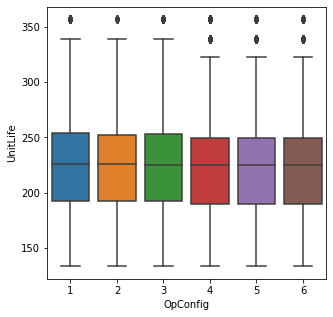

In [13]:
plt.figure(figsize = (5, 5))
sns.boxplot(x = trainUnitsData["OpConfig"], y = trainUnitsData["UnitLife"])

In looks like, perhaps an `OpConfig` setting of 1 is associated with higher median `UnitLife`, but the other configurations have nearly the same median `UnitLife`.

Let's look for sensor readings which have some correlation with our remaining useful life (`RUL`) variable. We'll do so with a correlation plot.

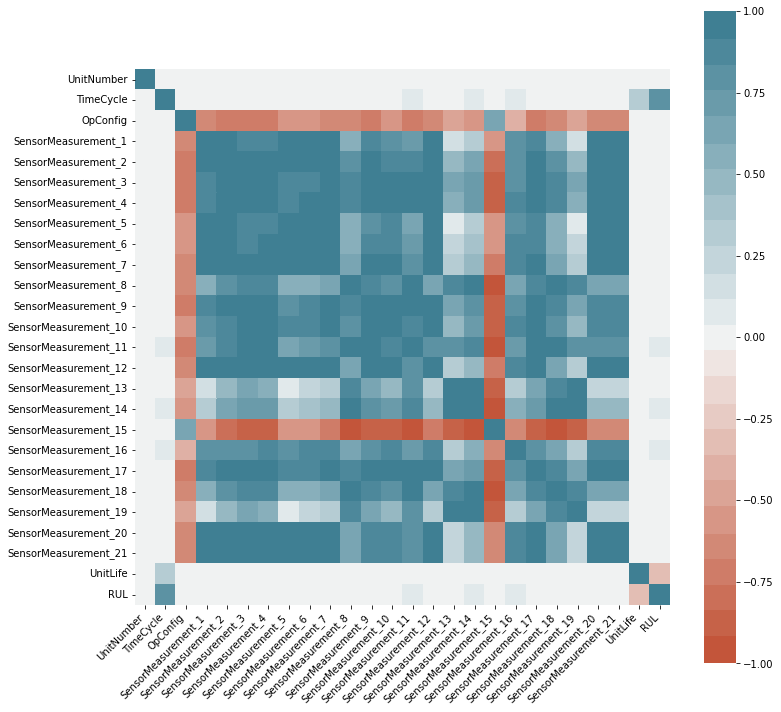

In [14]:
correlations = trainUnitsData.corr()

plt.figure(figsize = (12,12))
ax = sns.heatmap(
    correlations, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=25),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

There is no low-hanging fruit here. None of the raw sensor measurements streams or operational configuration correspond to `RUL`. This was expected for the operational configuration given the boxplot prior but we were hoping to see associations with the sensor readings.

Let's look at some of the sensor streams. We hope to see visible changes in the sensor measurements as we near the end of unit life. We'll plot all of the sensor readings associated with Unit 1.

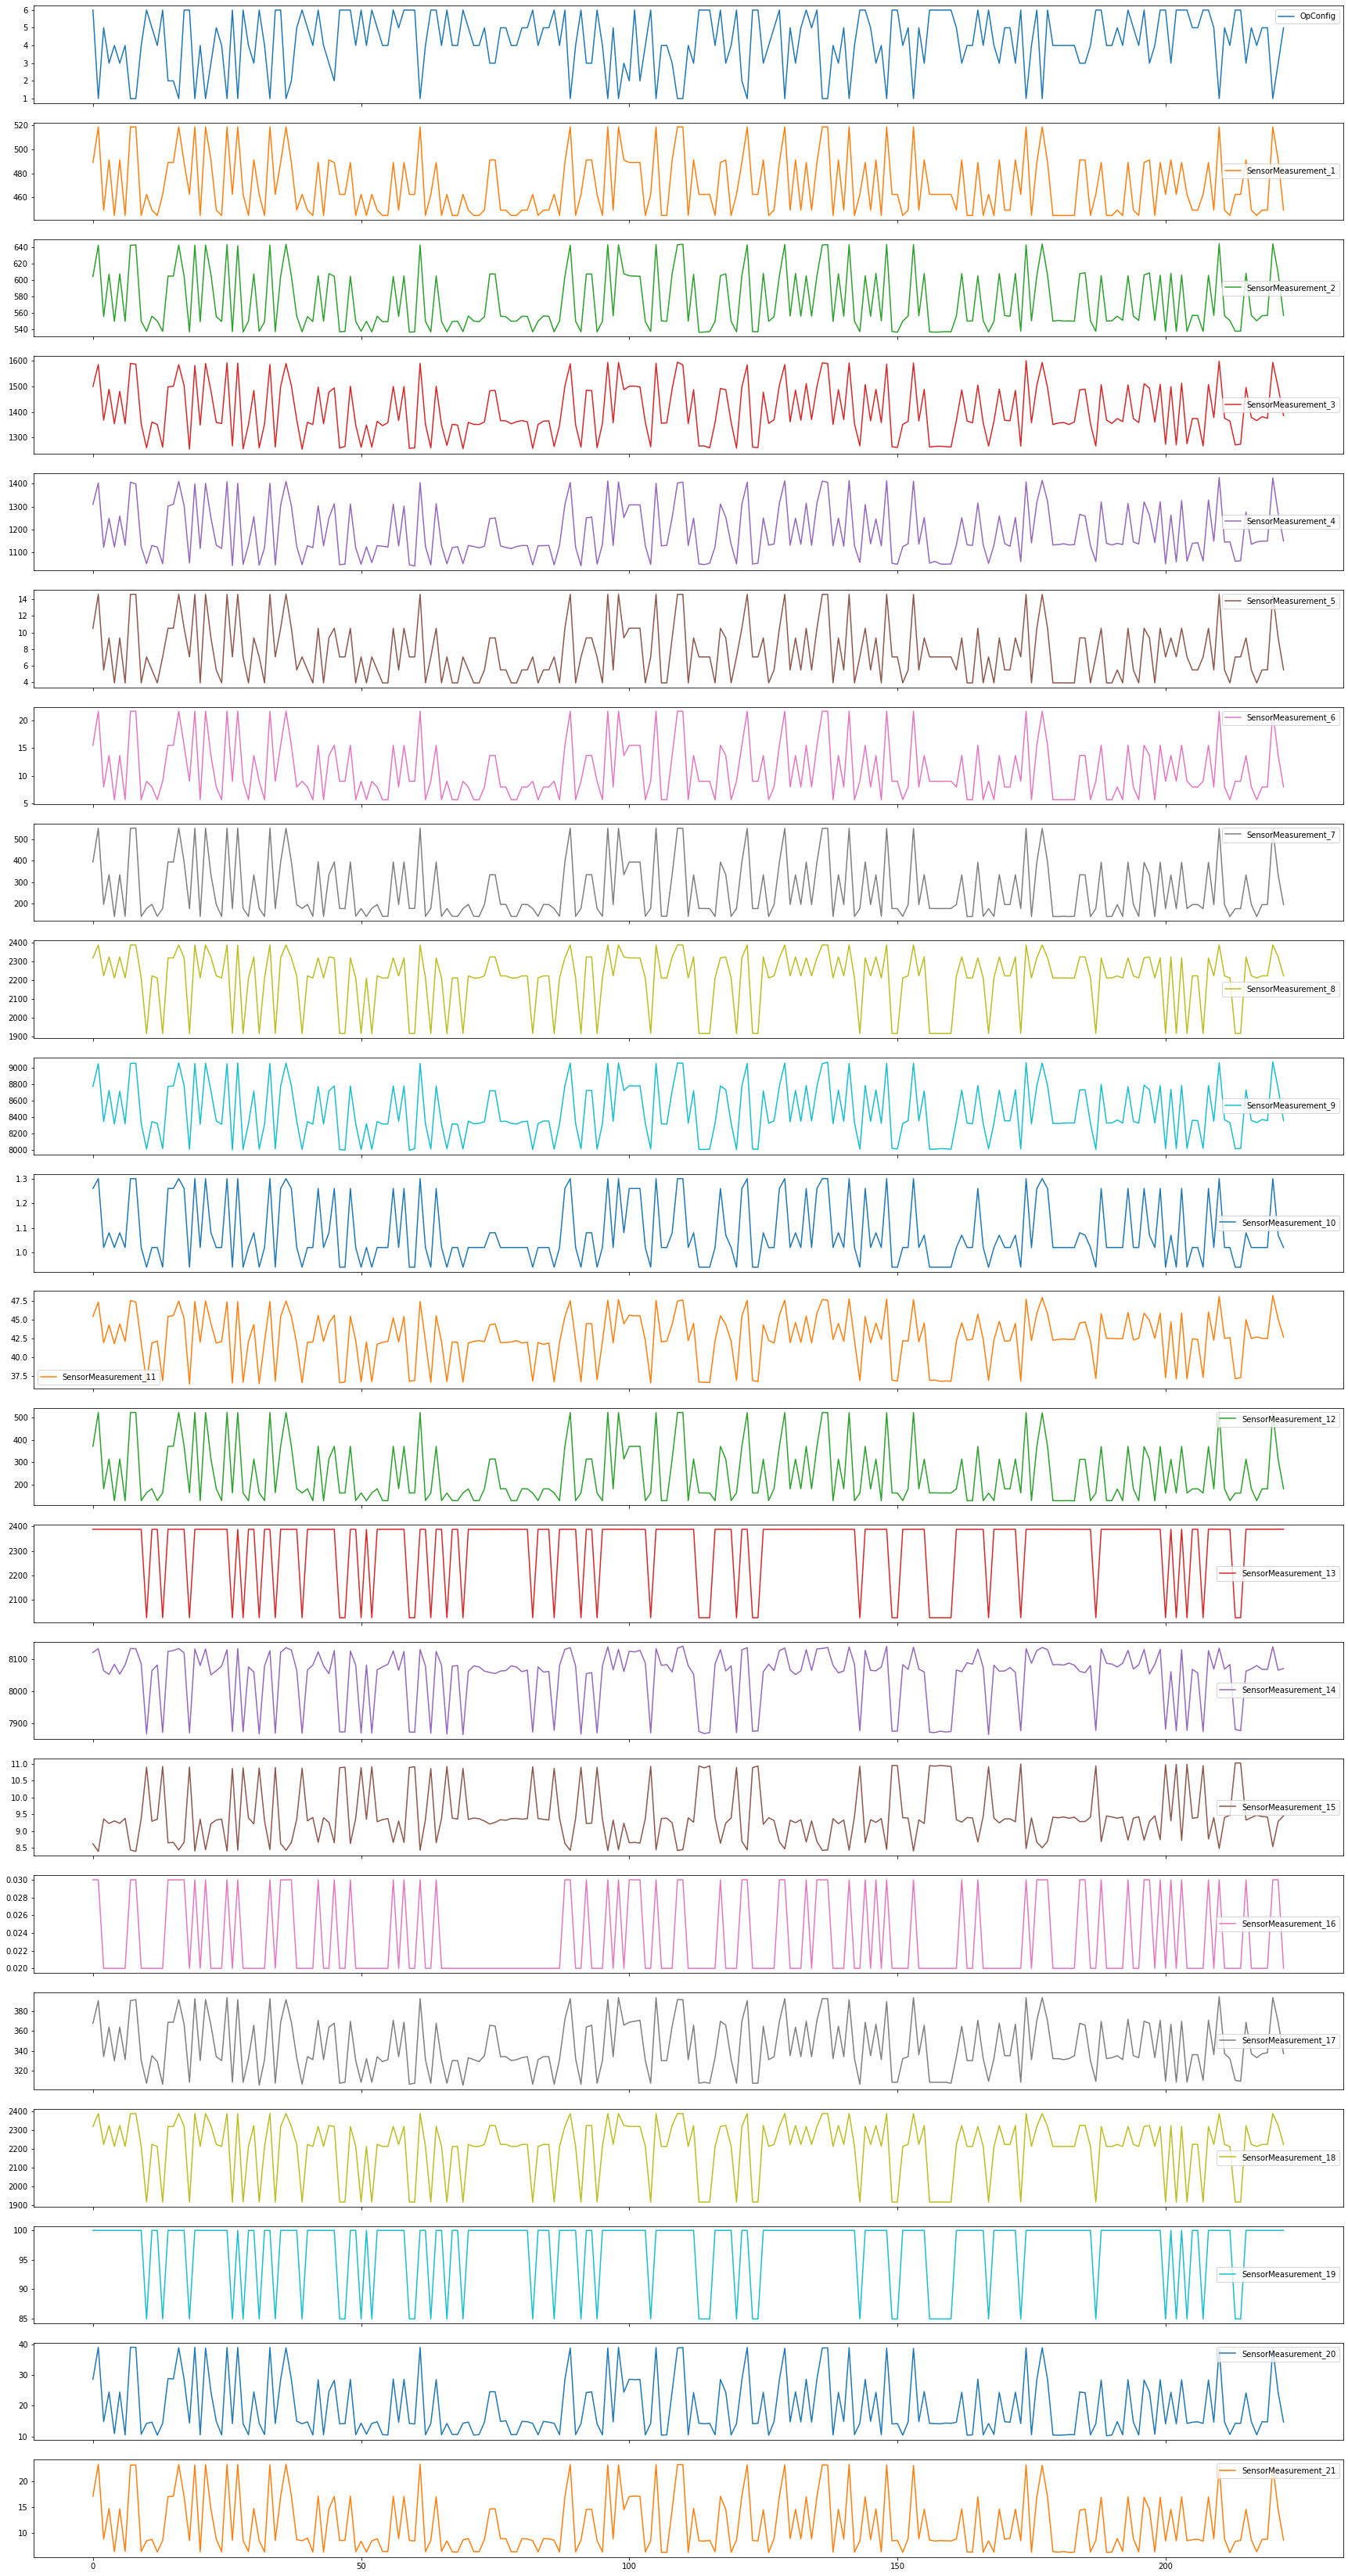

In [15]:
#Plot sensor readings over the life of Unit 1, the first unit in the training data
trainUnitsData[trainUnitsData["UnitNumber"] == 1].sort_values("RUL")[trainUnitsData.columns[2:-2]].plot(subplots = True, sharex = True, figsize = (30, 60));

We aren't seeing the changes we had hoped for in the raw streams plotted as time series. It can be verified that Unit 1 is not an anomaly by plotting the streams from several other units in the training set. We will notice similar results.

Let's look at the stream from a particular sensor (here Sensor 11) across all of the units. We'll remove some of the noise by taking a rolling average over a window of 100 cycles.

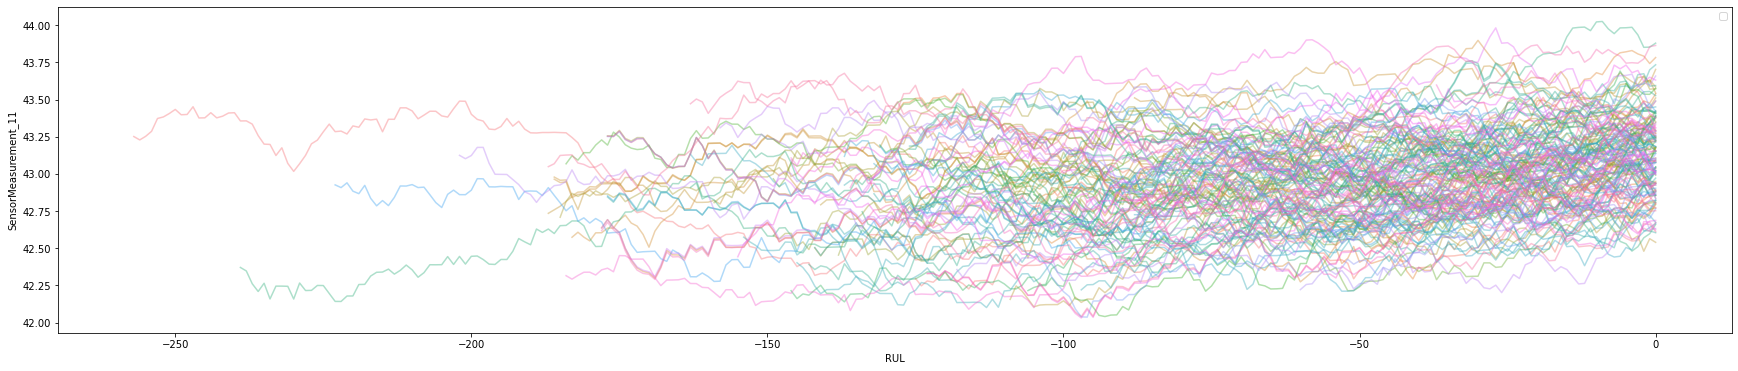

In [16]:
plt.figure(figsize = (30, 6))
sns.lineplot(x = trainUnitsData["RUL"], y = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_11"].transform(lambda x: x.rolling(100).mean()), hue = trainUnitsData["UnitNumber"].astype("string"), alpha = 0.4)
plt.legend("")

This is a lot ot digest - it looks like there may be a slight upward trajectory here, on average as we near the end of engine life. Let's look at a smaller subset of the units.

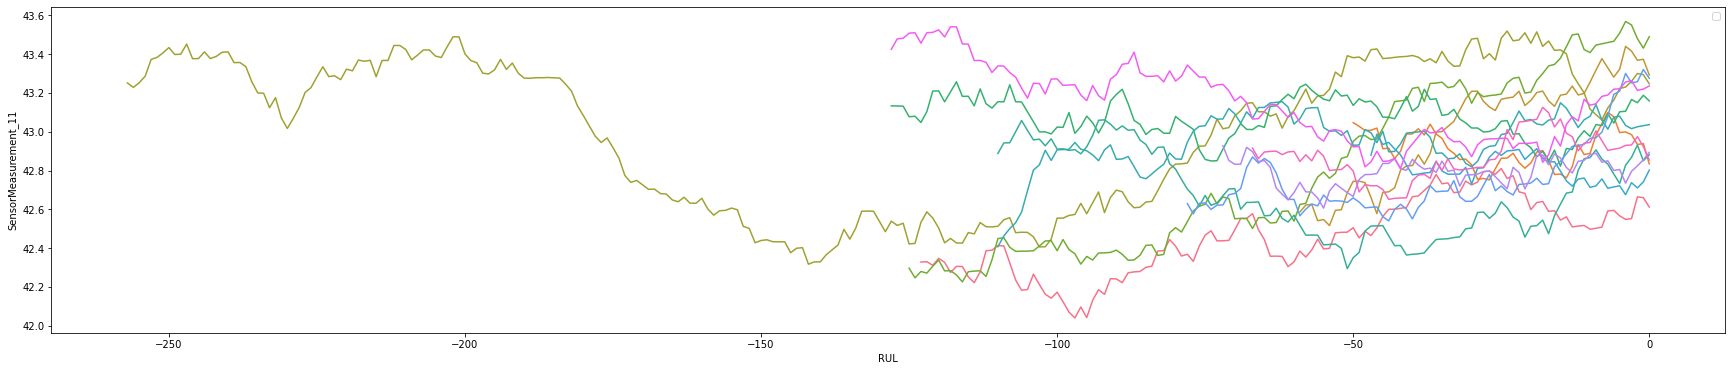

In [17]:
plt.figure(figsize = (30, 6))
sns.lineplot(x = trainUnitsData[trainUnitsData["UnitNumber"] < 20]["RUL"], y = trainUnitsData[trainUnitsData["UnitNumber"] < 20].groupby("UnitNumber")["SensorMeasurement_11"].transform(lambda x: x.rolling(100).mean()), hue = trainUnitsData[trainUnitsData["UnitNumber"] < 20]["UnitNumber"].astype("string"))
plt.legend("")

I'm less convinced after looking at the small subset. Let's just try a different view, and plot points instead. 

Once we do this, we gain some real insights as to the sensors which might indicate nearing an end of life. In particular, sensors 3, 4, 9, 11, and 14, with the possibility of 15 and 17 seem to indicate changed behaviors nearing their corresponding unit's end of life.

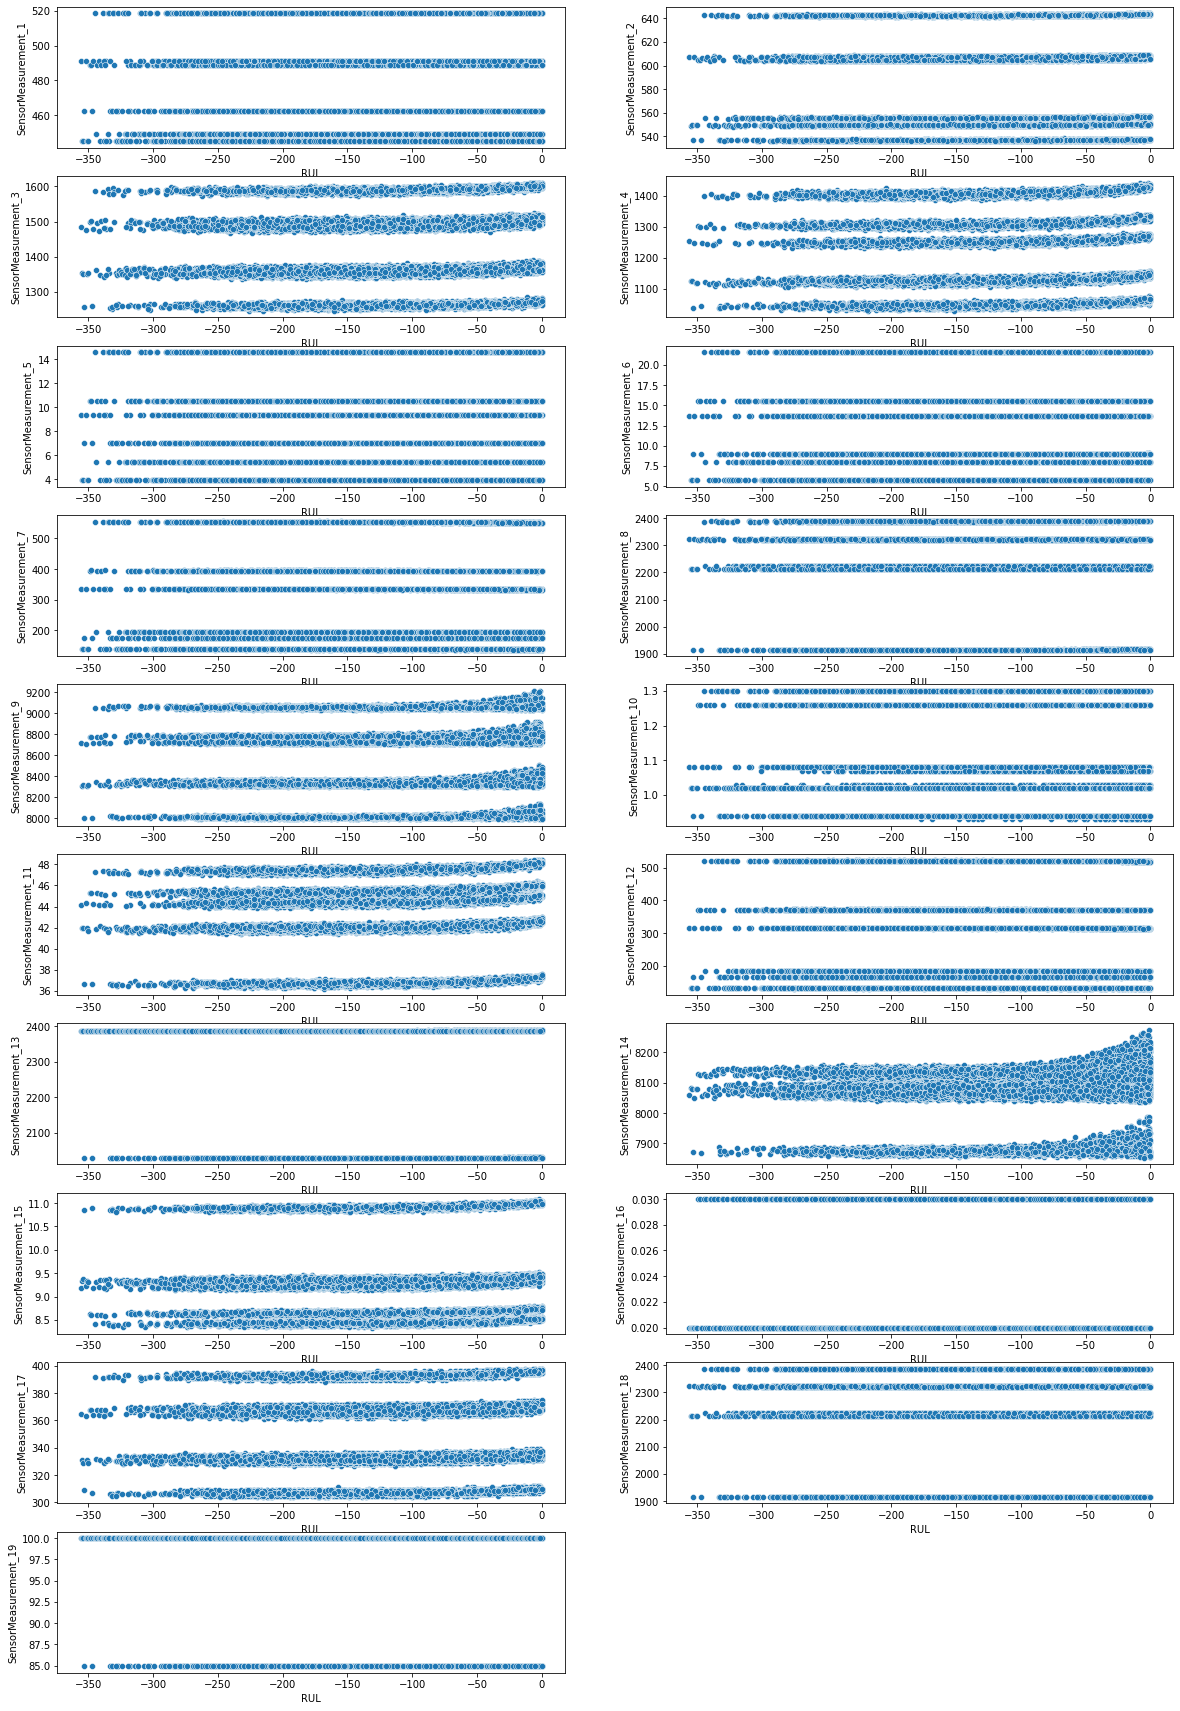

In [18]:
plt.figure(figsize = (20, 40))
for i in range(5, trainUnitsData.shape[1] - 2):
  plt.subplot(13, 2, i-4)
  sns.scatterplot(x = trainUnitsData["RUL"], y = trainUnitsData["SensorMeasurement_" + str(i-4)])

Let's build the same plot, but color the observations according to the `OpConfig`.

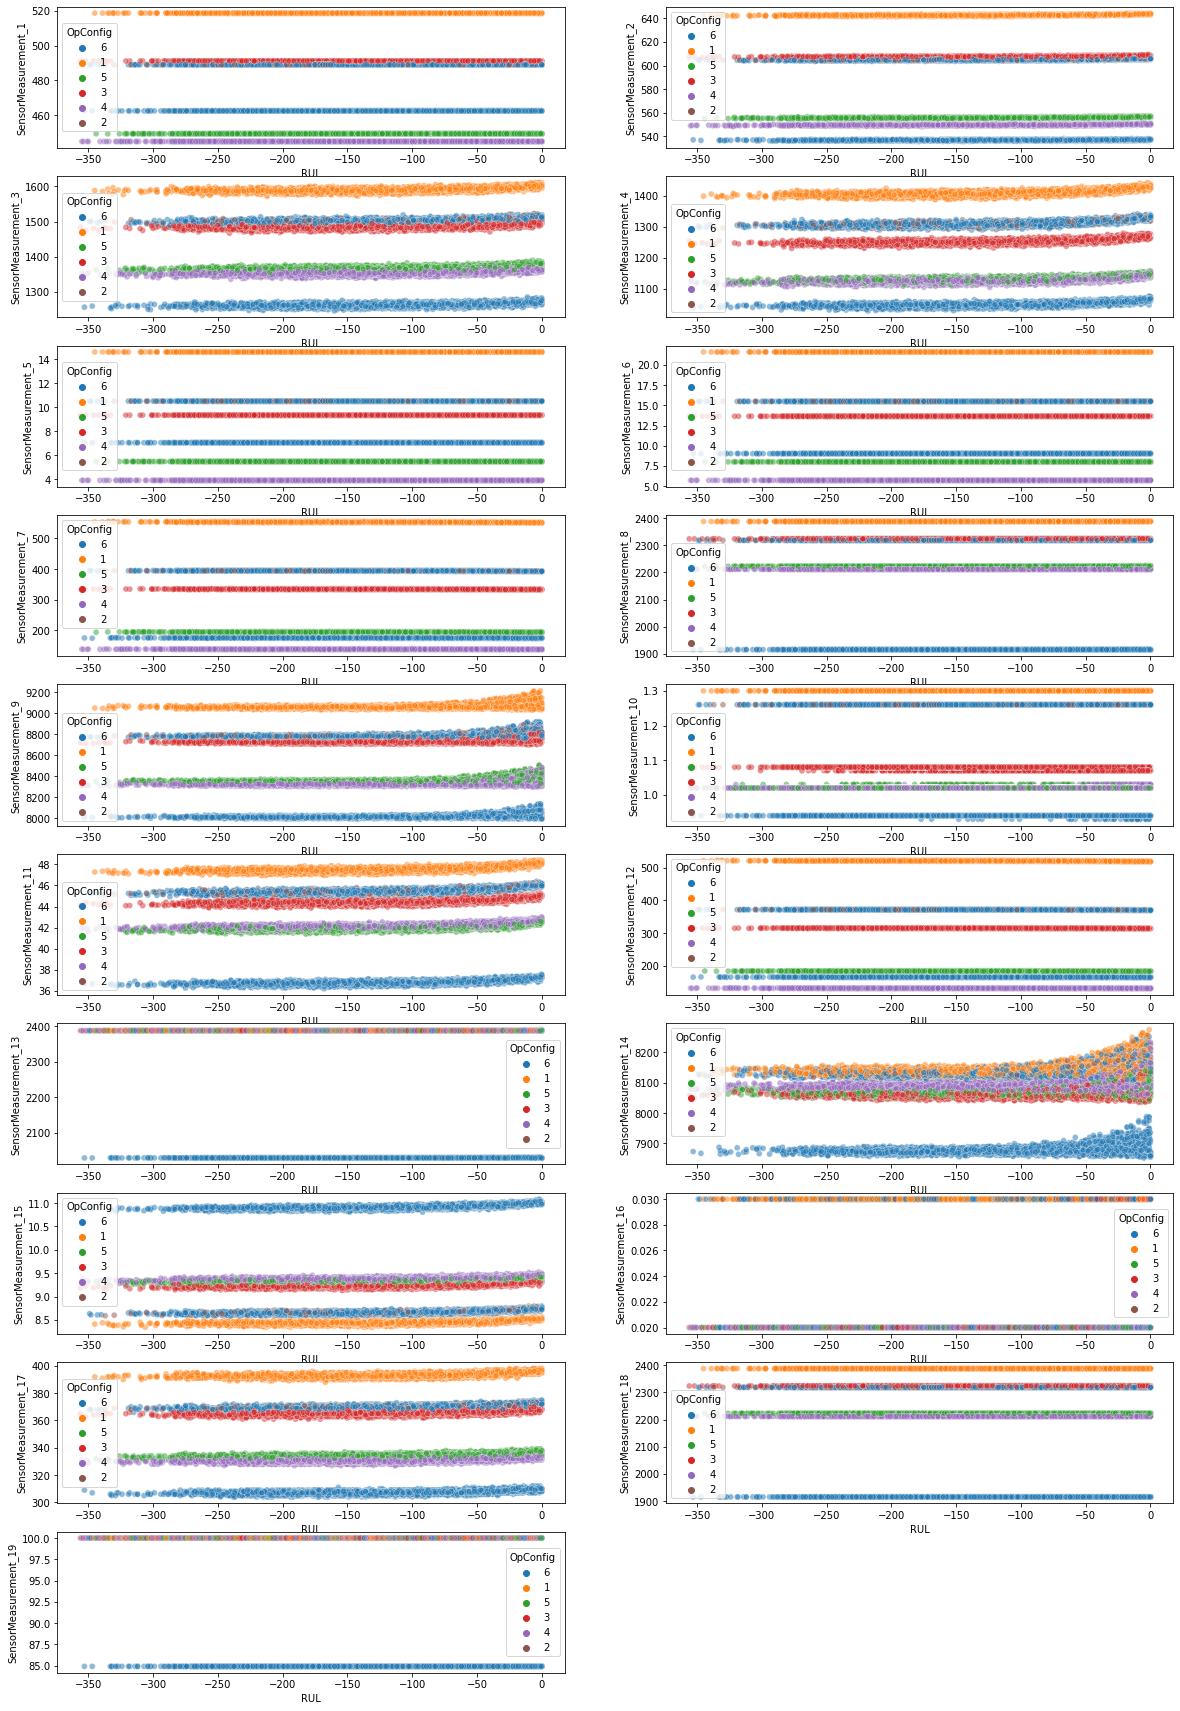

In [19]:
plt.figure(figsize = (20, 40))
for i in range(5, trainUnitsData.shape[1] - 2):
  plt.subplot(13, 2, i-4)
  sns.scatterplot(x = trainUnitsData["RUL"], y = trainUnitsData["SensorMeasurement_" + str(i-4)], hue = trainUnitsData["OpConfig"].astype(str), alpha = 0.5)

Interestingly, we can see that the streamed sensor readings are very much dependent on the operational configuration. Let's take one more look at this plot, grouping by `RUL` and plotting the mean sensor reading.

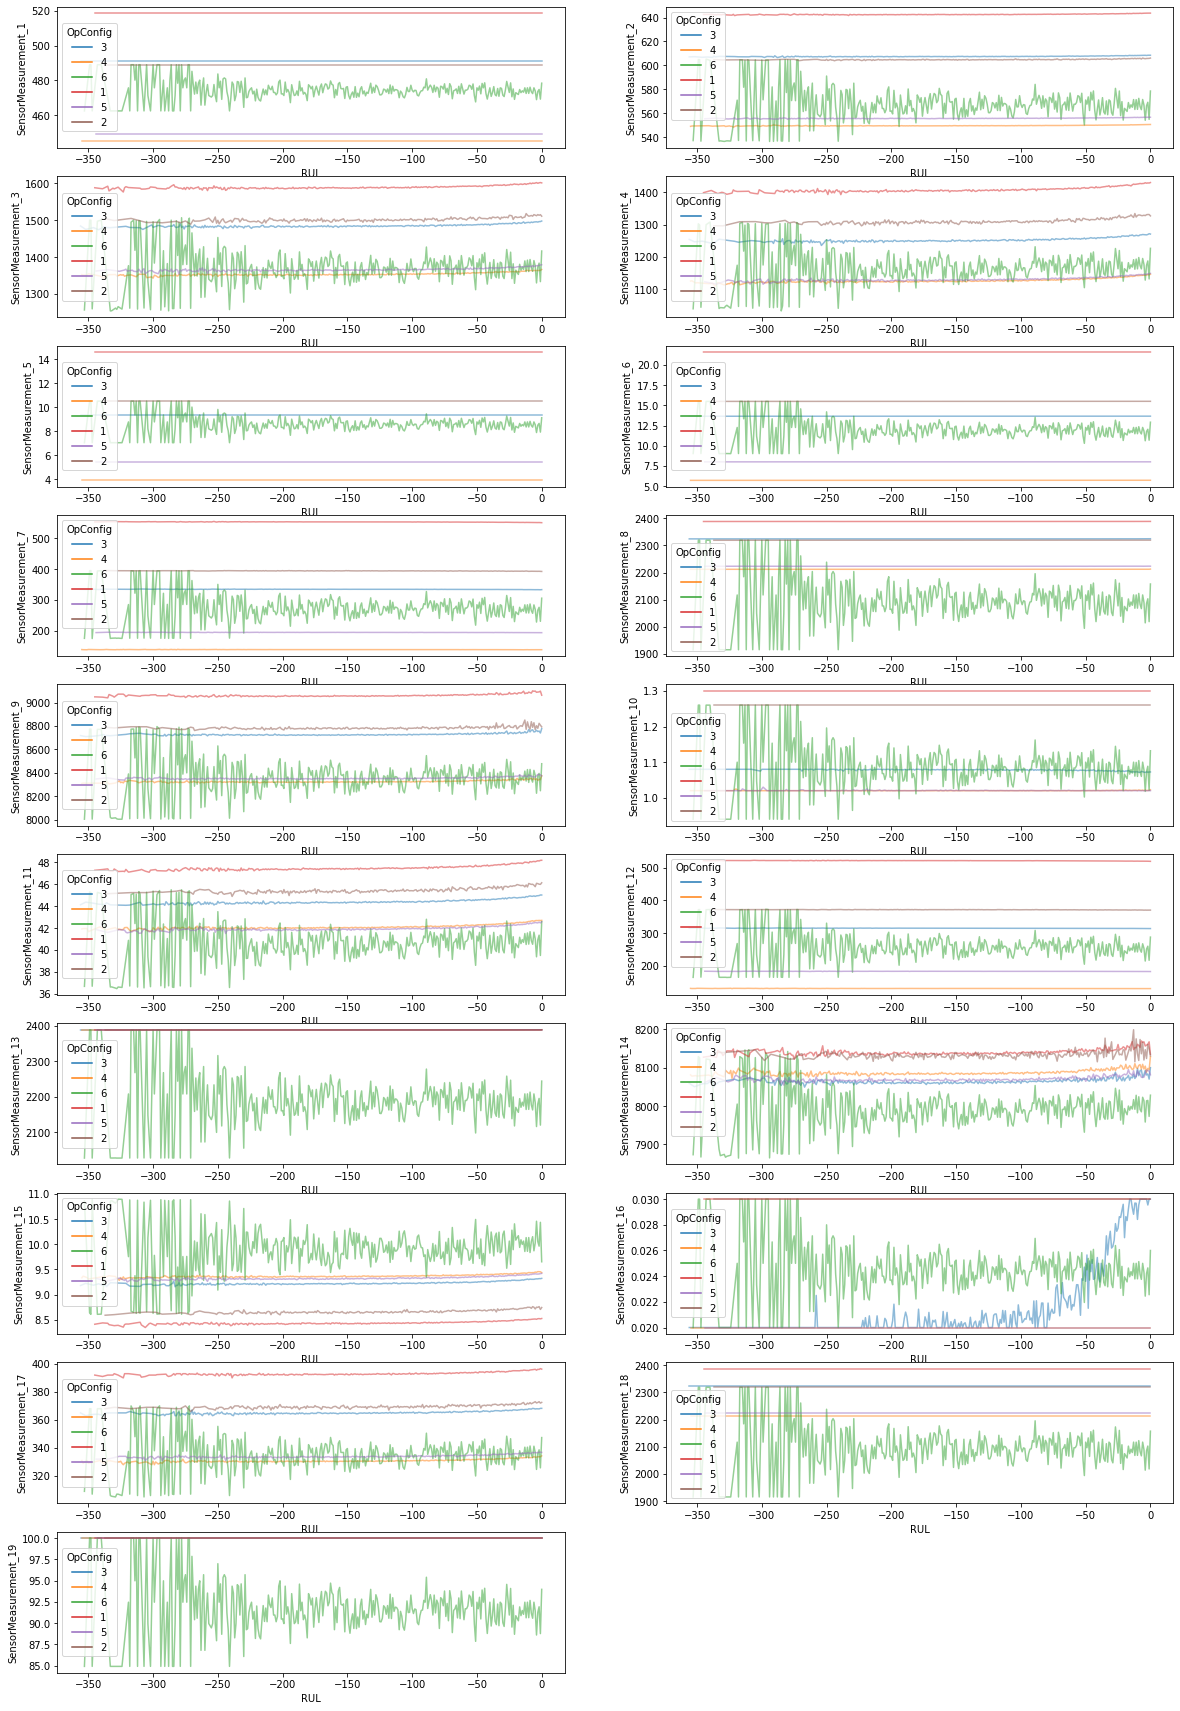

In [20]:
plt.figure(figsize = (20, 40))
for i in range(5, trainUnitsData.shape[1] - 2):
  plt.subplot(13, 2, i-4)
  sns.lineplot(x = trainUnitsData.groupby(["RUL", "OpConfig"], as_index = False).agg("mean")["RUL"], y = trainUnitsData.groupby(["RUL", "OpConfig"], as_index = False).agg("mean")["SensorMeasurement_" + str(i-4)], hue = trainUnitsData.groupby(["RUL", "OpConfig"], as_index = False).agg("mean")["OpConfig"].astype(str), alpha = 0.5)

We've identified that the discrete sensor states highlighted earlier correspond to the Operational Configuration (`OpConfig`). The particular behavior changes in the visuals indicate that looking for the following may be useful.

+ Nearing the end of life of a unit sensors 3, 4, 11, 14, 15, and to some extent 17, show rising means in readings.
+ In these aggregated plots, it seems that for engines operating in configuration 6 have about 175 cycles remaining on their life once the sensor readings become less variable. This, however, may be an artifact of the aggregation that was done and having a fewer engines contributing to the averaging being done for very long-life engines.

Before proceding with these as our primary insights, let's check these trends on a small single unit. From the plot below, we can see that the problem of identifying signals of end of life (and therefore predicting remaining uselful life) will be more difficult on an individual unit, as expected.

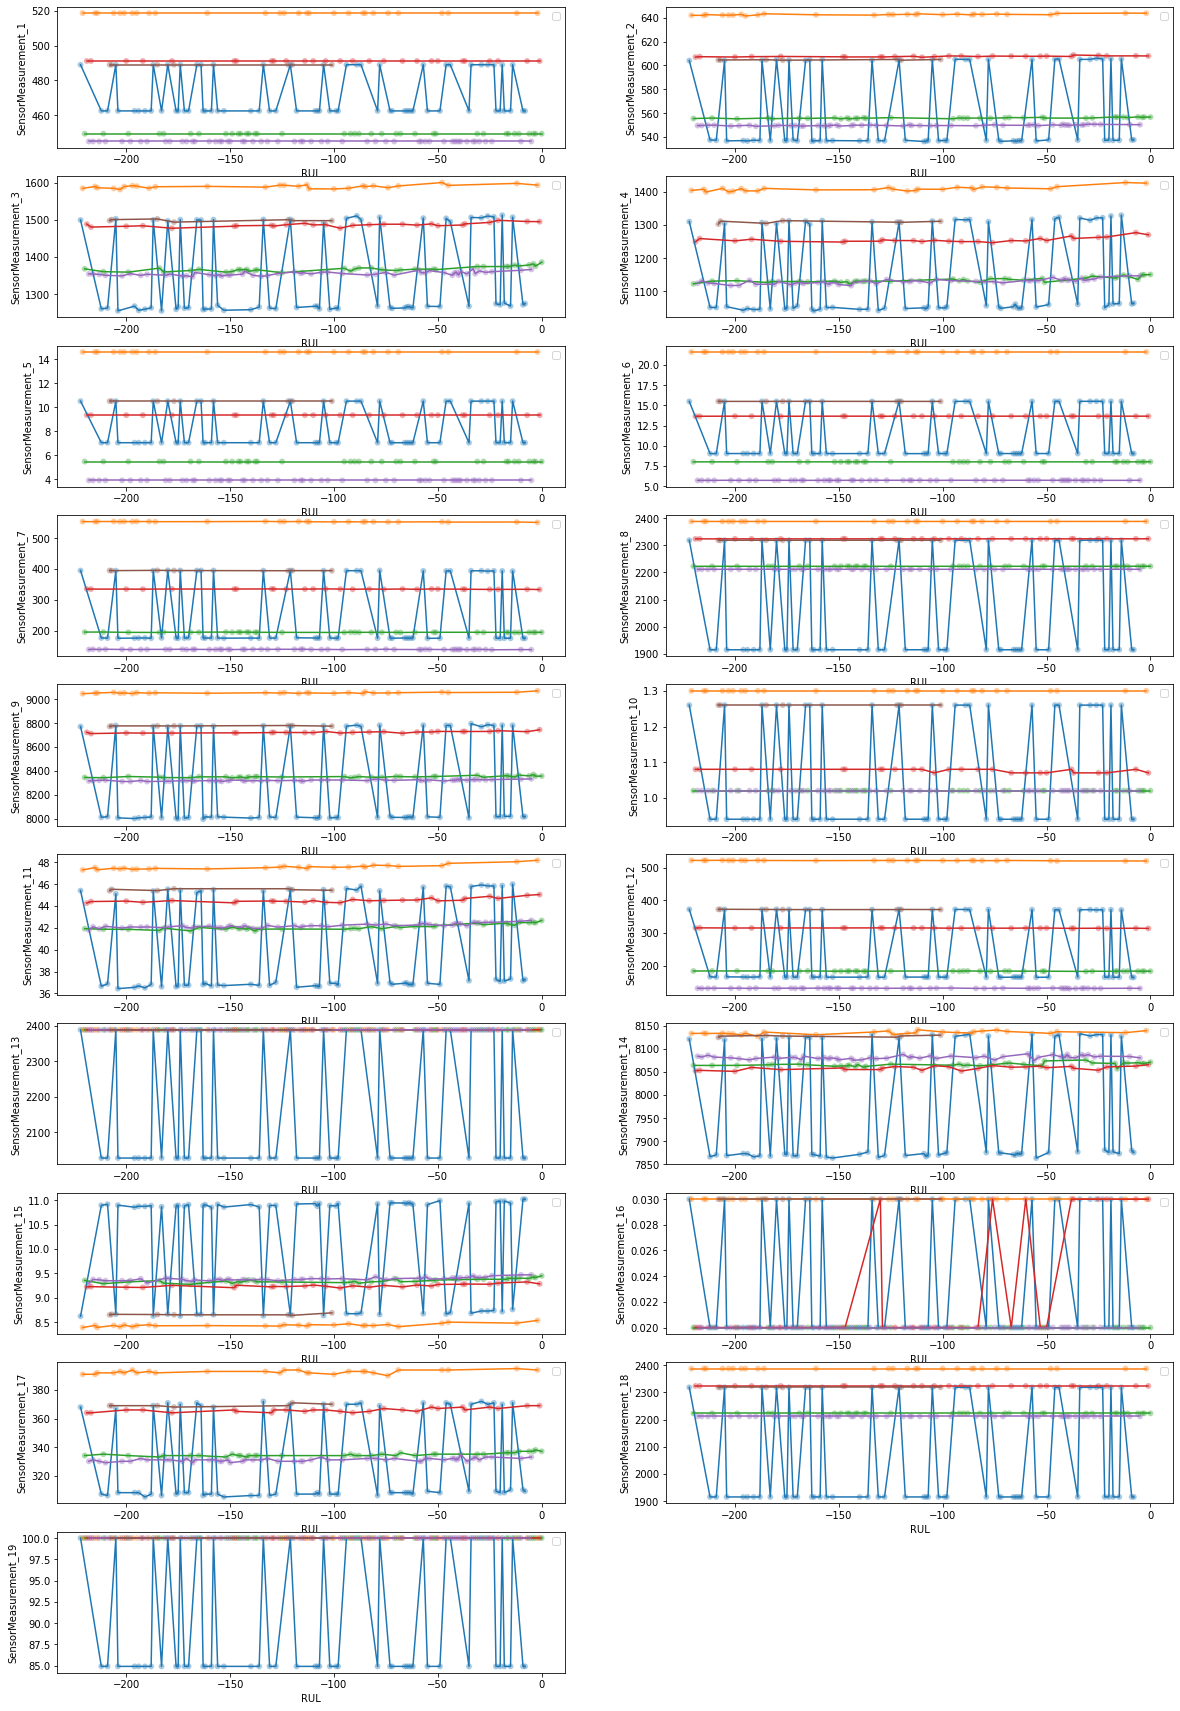

In [21]:
plt.figure(figsize = (20, 40))
for i in range(5, trainUnitsData.shape[1] - 2):
  plt.subplot(13, 2, i-4)
  sns.lineplot(x = trainUnitsData[trainUnitsData["UnitNumber"] == 1]["RUL"], y = trainUnitsData[trainUnitsData["UnitNumber"]  == 1]["SensorMeasurement_" + str(i-4)], hue = trainUnitsData[trainUnitsData["UnitNumber"]  == 1]["OpConfig"].astype(str))
  sns.scatterplot(x = trainUnitsData[trainUnitsData["UnitNumber"] == 1]["RUL"], y = trainUnitsData[trainUnitsData["UnitNumber"]  == 1]["SensorMeasurement_" + str(i-4)], hue = trainUnitsData[trainUnitsData["UnitNumber"]  == 1]["OpConfig"].astype(str), alpha = 0.4)
  plt.legend("")

The tendencies are certainly less obvious here, but we do see some evidence of the changing sensor readings. This is our most promising trajectory so far, so let's continue with it.

## Further Tidying: Removing Unhelpful Features and Engineering New Ones

We'll start by trimming down our dataset and engineering new features. We'll do this with the initial dataset to minimize the amount of duplication required, but ensure that there is no information leakage from test or safe engine units into the training data.  

In [22]:
data["OpConfig"] = len(data)*[0]

for i in range(len(data)):
  if data.iloc[i, 4] > 80:
    data.iloc[i, -1] = 1
  
  elif data.iloc[i, 2] < 10:
    data.iloc[i, -1] = 2
  
  elif data.iloc[i, 4] < 20:
    data.iloc[i, -1] = 3
  
  elif data.iloc[i, 2] > 40:
    data.iloc[i, -1] = 4

  elif data.iloc[i, 2] > 30:
    data.iloc[i, -1] = 5
  
  else:
    data.iloc[i, -1] = 6

dataForModeling = data[["UnitNumber", "TimeCycle", "OpConfig", "SensorMeasurement_3", "SensorMeasurement_4", "SensorMeasurement_9", "SensorMeasurement_11", "SensorMeasurement_14", "SensorMeasurement_15", "SensorMeasurement_17", "RUL"]].copy()
dataForModeling.head()

UnitNumber  TimeCycle  OpConfig  SensorMeasurement_3  SensorMeasurement_4  \
0           1          1         6              1499.45              1309.95   
1           1          2         1              1584.55              1403.96   
2           1          3         5              1368.17              1122.49   
3           1          4         3              1488.44              1249.18   
4           1          5         4              1354.48              1124.32   

   SensorMeasurement_9  SensorMeasurement_11  SensorMeasurement_14  \
0              8770.20                 45.40               8120.83   
1              9045.76                 47.29               8132.87   
2              8343.91                 41.92               8063.84   
3              8721.53                 44.26               8052.30   
4              8314.56                 41.79               8083.67   

   SensorMeasurement_15  SensorMeasurement_17  RUL  
0                8.6216                   368 -222  
1                8.3907                   391 -221  
2                9.3557                   334 -220  
3                9.2231                   364 -219  
4                9.2986                   330 -218

Let's get dummy variables for that `OpConfig` feature, since it isn't really a numerical variable.

In [23]:
dataForModeling_dummies = pd.get_dummies(dataForModeling, columns = ["OpConfig"], drop_first = False)
dataForModeling_dummies.head()

UnitNumber  TimeCycle  SensorMeasurement_3  SensorMeasurement_4  \
0           1          1              1499.45              1309.95   
1           1          2              1584.55              1403.96   
2           1          3              1368.17              1122.49   
3           1          4              1488.44              1249.18   
4           1          5              1354.48              1124.32   

   SensorMeasurement_9  SensorMeasurement_11  SensorMeasurement_14  \
0              8770.20                 45.40               8120.83   
1              9045.76                 47.29               8132.87   
2              8343.91                 41.92               8063.84   
3              8721.53                 44.26               8052.30   
4              8314.56                 41.79               8083.67   

   SensorMeasurement_15  SensorMeasurement_17  RUL  OpConfig_1  OpConfig_2  \
0                8.6216                   368 -222           0           0   
1                8.3907                   391 -221           1           0   
2                9.3557                   334 -220           0           0   
3                9.2231                   364 -219           0           0   
4                9.2986                   330 -218           0           0   

   OpConfig_3  OpConfig_4  OpConfig_5  OpConfig_6  
0           0           0           0           1  
1           0           0           0           0  
2           0           0           1           0  
3           1           0           0           0  
4           0           1           0           0

Now that we've isolated the most relevant predictors available to us and have constructed dummy variables to take the place of the `OpConfig` feature, we are ready to move on to the model construction phase. See you in the `ModelBuildAndAssess` notebook where we'll construct, train, and assess the performance of an LSTM in predicting remaining useful life for our engines.